# Step 1: Import data from kaggle to google colab 

---

To do this, we will follow the following steps-


*   Mount the drive
*   Dowload the data from kaggle
*   Unzip this data





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sampadasathe","key":"1c9012dad31140ee61af601e3ce08b6c"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 96% 260M/271M [00:02<00:00, 95.2MB/s]
100% 271M/271M [00:02<00:00, 97.0MB/s]
100% 544M/544M [00:05<00:00, 82.9MB/s]

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 132MB/s]


In [0]:
# Create data directory and unzip training and testing data
!mkdir data && unzip test.zip -d data/
!unzip train.zip -d data

# Step 2: Pre-process photos

Add labels to photos using listdir library.



In [0]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['data/train/', 'data/test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'data/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'data/train/'
	if random() < val_ratio:
		dst_dir = 'data/test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [10]:
import os
import pandas as pd
# Create DataFrame to visualize dataset
PATH = 'data/'
filenames = os.listdir(f'{PATH}train')
labels = []
for name in filenames:
    label = name.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df.head()

,filename,label
0,dog.8619.jpg,1
1,cat.9987.jpg,0
2,dog.1018.jpg,1
3,dog.1678.jpg,1
4,cat.2263.jpg,0


In [11]:
df.pivot_table(index='label', aggfunc=len).sort_values('filename', ascending=False)

,filename
label,
0,12500
1,12500


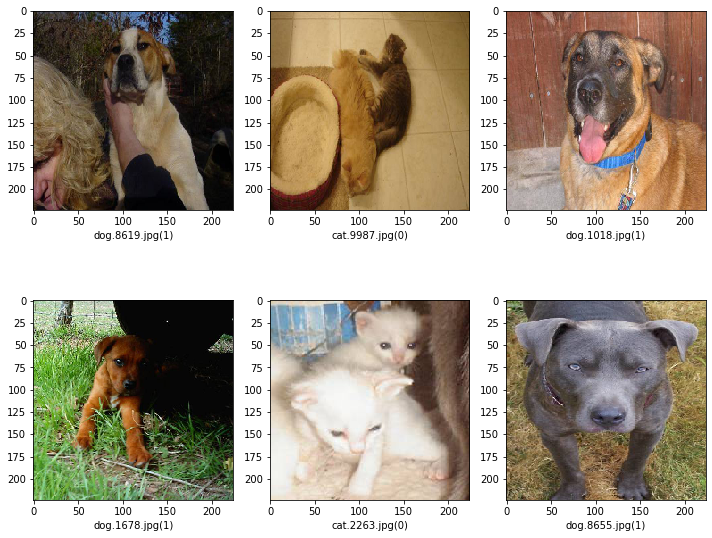

In [15]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 

# See sample images
sample_train = df.head(6)
sample_train.head()
plt.figure(figsize=(10, 24))
for index, row in sample_train.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(PATH+'/train/'+filename, target_size=[224,224])
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Step 3: Build the model

In [0]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	return history

# entry point, run the test harness
history = run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 115s 391ms/step - loss: 0.5448 - acc: 0.9572 - val_loss: 0.2922 - val_acc: 0.9716
Epoch 2/10
293/293 [==============================] - 112s 381ms/step - loss: 0.0994 - acc: 0.9777 - val_loss: 0.0748 - val_acc: 0.9745
Epoch 3/10
293/293 [==============================] - 111s 377ms/step - loss: 0.0279 - acc: 0.9921 - val_loss: 0.0842 - val_acc: 0.9706
Epoch 4/10
293/293 [==============================] - 112s 382ms/step - loss: 0.0114 - acc: 0.9979 - val_loss: 0.0861 - val_acc: 0.9738
Epoch 5/10
293/293 [==============================] - 112s 382ms/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0964 - val_acc: 0.9740
Epoch 6/10
293/293 [==============================] - 111s 380ms/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.1026 - val_acc: 0.9741
Epoch 7/10
293/293 [==============================] - 112s 382ms/step - loss: 0.0040 - acc: 0.9997 

In [0]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	

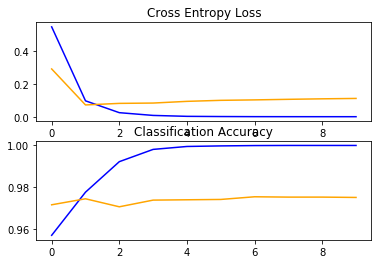

In [0]:
summarize_diagnostics(history)

# Try a model by training the last 3 layers of the pre loaded model. Let's see if the accuracy improves!


In [0]:
def define_model_train_vg16():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers[:-4]:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
def run_test_harness():
	# define model
	model = define_model_train_vg16()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	return history

In [0]:
history = run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 116s 396ms/step - loss: 0.5710 - acc: 0.9574 - val_loss: 0.4445 - val_acc: 0.9667
Epoch 2/10
293/293 [==============================] - 110s 377ms/step - loss: 0.2817 - acc: 0.9747 - val_loss: 0.1591 - val_acc: 0.9737
Epoch 3/10
293/293 [==============================] - 111s 378ms/step - loss: 0.0589 - acc: 0.9844 - val_loss: 0.0703 - val_acc: 0.9746
Epoch 4/10
293/293 [==============================] - 111s 377ms/step - loss: 0.0207 - acc: 0.9945 - val_loss: 0.0786 - val_acc: 0.9748
Epoch 5/10
293/293 [==============================] - 110s 377ms/step - loss: 0.0094 - acc: 0.9985 - val_loss: 0.0830 - val_acc: 0.9765
Epoch 6/10
293/293 [==============================] - 109s 373ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.0931 - val_acc: 0.9754
Epoch 7/10
293/293 [==============================] - 109s 372ms/step - loss: 0.0050 - acc: 0.9997 

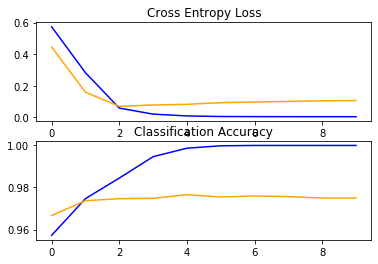

In [0]:
summarize_diagnostics(history)

# Try Regularization


In [0]:
from keras.layers import Dropout
from keras.regularizers import l2
def define_model_train_vg16_regularization():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers[:-4]:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
def run_test_harness_reg():
	# define model
	model = define_model_train_vg16_regularization()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	return history

In [0]:
history = run_test_harness_reg()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 124s 424ms/step - loss: 2.6828 - acc: 0.9497 - val_loss: 2.3888 - val_acc: 0.9757
Epoch 2/10
293/293 [==============================] - 120s 408ms/step - loss: 2.2371 - acc: 0.9838 - val_loss: 2.1317 - val_acc: 0.9722
Epoch 3/10
293/293 [==============================] - 118s 403ms/step - loss: 1.9653 - acc: 0.9954 - val_loss: 1.9164 - val_acc: 0.9765
Epoch 4/10
293/293 [==============================] - 116s 395ms/step - loss: 1.7410 - acc: 0.9991 - val_loss: 1.7109 - val_acc: 0.9810
Epoch 5/10
293/293 [==============================] - 115s 394ms/step - loss: 1.5471 - acc: 0.9996 - val_loss: 1.5335 - val_acc: 0.9810
Epoch 6/10
293/293 [==============================] - 115s 392ms/step - loss: 1.3756 - acc: 0.9997 - val_loss: 1.3765 - val_acc: 0.9822
Epoch 7/10
293/293 [==============================] - 114s 388ms/step - loss: 1.2235 - acc: 0.9998 

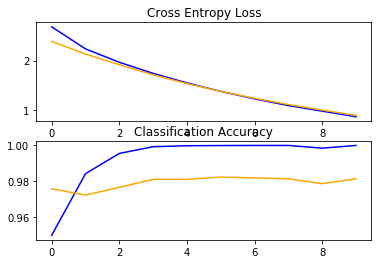

In [0]:
summarize_diagnostics(history)

# Combination of regularization and letting the last few layers of vgg16 helped improve the accuracy


*   I will now use the entire training data to build the model
*   I will then save this model to run prediction on the test set





In [0]:
from os import makedirs
from os import listdir
from shutil import copyfile
# create directories
dataset_home = 'finalize_dogs_vs_cats/'
# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'data/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	if file.startswith('cat'):
		dst = dataset_home + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + 'dogs/'  + file
		copyfile(src, dst)

In [0]:
model = define_model_train_vg16_regularization()
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
	class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=1)

Found 25000 images belonging to 2 classes.
Epoch 1/10
391/391 [==============================] - 121s 309ms/step - loss: 2.6342 - acc: 0.9485
Epoch 2/10
391/391 [==============================] - 118s 302ms/step - loss: 2.1266 - acc: 0.9837
Epoch 3/10
391/391 [==============================] - 118s 301ms/step - loss: 1.8073 - acc: 0.9918
Epoch 4/10
391/391 [==============================] - 118s 302ms/step - loss: 1.5331 - acc: 0.9980
Epoch 5/10
391/391 [==============================] - 119s 303ms/step - loss: 1.3082 - acc: 0.9994
Epoch 6/10
391/391 [==============================] - 118s 301ms/step - loss: 1.1182 - acc: 0.9997
Epoch 7/10
391/391 [==============================] - 115s 294ms/step - loss: 0.9563 - acc: 0.9998
Epoch 8/10
391/391 [==============================] - 116s 296ms/step - loss: 0.8180 - acc: 0.9998
Epoch 9/10
391/391 [==============================] - 119s 304ms/step - loss: 0.6998 - acc: 0.9998
Epoch 10/10
391/391 [==============================] - 118s 301ms/

In [0]:
model.save('final_model_reg.h5')

# Test the model on the image of a dog to see how it is performing!


In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.jpg')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
 
# entry point, run the example
run_example()

[1.]


YAYY! My model correctly predicted the dog! Let's pass the test data set to it and submit it on kaggle!

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

def run_example(filename):
	# load the image
	img = load_image(filename)
	# predict the class
	prediction = model.predict(img)
	return prediction


In [0]:
submission = pd.read_csv("sample_submission.csv")

In [0]:
submission.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [0]:
model = load_model('final_model_reg.h5')

In [0]:
submission['label'] = submission['id'].apply(lambda data: run_example('data/test/'+str(data)+'.jpg')[0][0] )
submission.to_csv("KaggleSubmit.csv")